# Exploring Class Activation Maps for Sport Image Classification

**Introduction:**

Welcome to HES-Xplain, our interactive platform designed to facilitate explainable artificial intelligence (XAI) techniques. In this use case, we dive into sport image classification and showcase the power of Class Activation Maps (CAM) as an interpretability tool.

CAM allows us to visualize the regions of an image that contribute most to the model's classification decision. By overlaying heatmaps onto the original images, we gain insights into the model's attention and its understanding of different sports.

Our goal is to demonstrate how HES-Xplain empowers users to explore and interpret sport image classifiers effectively. We'll focus on a specific image classification task using a pre-trained model. By the end of this use case, you'll have a solid understanding of CAM and how to integrate it into your own sport image classification projects.

**Objectives:**

1. Understand the importance of interpretability in sport image classification.
2. Introduce Class Activation Maps (CAM) as a powerful XAI technique.
3. Showcase the capabilities of HES-Xplain in implementing CAM.
4. Provide practical insights into applying CAM to sport image classifiers through an interactive notebook.
5. Foster a community of XAI enthusiasts and practitioners.

**Outline:**

1. Dataset and Problem Statement.
2. Model Architecture.
3. Training the Model.
4. Evaluation and Performance Metrics.
5. Class Activation Maps (CAM).
6. Implementing CAM.
7. Visualizing CAM Results.
8. Improving your model with CAM
9. Conclusion.
10. References.

Through this use case, we aim to empower users to grasp the potential of CAM as a tool for transparent and interpretable sport image classification. With HES-Xplain, we make XAI accessible, helping users build trust in their models and make informed decisions.


## Dataset and Problem Statement

The sport image classification dataset used in this use case consists of approximately 15,000 images, covering 100 different sports categories. This dataset, available on [Kaggle](https://www.kaggle.com/datasets/gpiosenka/sports-classification), contains a total of 13,493 train images, 500 test images, and 500 validation images. The images are in JPG format and have dimensions of 224x224 pixels with 3 color channels.

**Problem Statement:** Our objective is to build a robust image classifier capable of accurately classifying sport images among the 100 predefined sports categories. The nature of the dataset, comprising images of various sports, makes it particularly suitable for introducing and visualizing XAI techniques. By leveraging deep learning techniques and Class Activation Maps (CAM), we aim to not only achieve high classification performance but also gain insights into the discriminative regions within the images that contribute to the classification decisions.


In [1]:
# global imports

import sys
import os
sys.path.append("/mnt/remote/workspaces/arthur.babey/hes-xplain-arthur/use_case_sport_classification/")

import torch
import json
import pandas as pd
import numpy as np
import torch.nn as nn

from PIL import Image
from scripts.sport_dataset import SportsData
from scripts.finetuneefficientnet import FineTunedEfficientNet
from scripts.evaluate import evaluate
from scripts.helpers import *
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [2]:
!python ../scripts/train.py --name test

Traceback (most recent call last):
  File "../scripts/train.py", line 3, in <module>
    from scripts.helpers import *
ModuleNotFoundError: No module named 'scripts'


In [21]:
# set global variables

home_path = "/home/arthur.babey/workspace/hes-xplain-arthur/use_case_sport_classification/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with open('../data/class_dict.json', 'r') as file:
    class_dict = json.load(file)
class_labels = list(class_dict.values())
train_loader, val_loader, test_loader = get_dataloaders()

## Load the Model

In this use case, we leverage the power of transfer learning and fine-tuning by utilizing a pre-trained model. Specifically, we will be using a fine-tuned EfficientNet model that has already learned valuable features from a large-scale dataset. To perform inference with this model, we will need to include the class definition script.

**Class Definition Script:**
You can find the class definition script (`class.py`) in the `scripts` directory of this notebook. The script contains the necessary custom class definitions and functions required for the sport image classification task. Make sure to include and import this script in your code to ensure proper model instantiation and inference.

To load the fine-tuned weights into the model, you can use the following code snippet:

```python
import torch
from scripts.class import YourCustomModelClass

# Create an instance of your PyTorch model
model = YourCustomModelClass()

# Load the fine-tuned weights into the model
model.load_state_dict(torch.load("path_to_your_fine_tuned_weights.pth"))

# Set the model to evaluation mode
model.eval()

# Perform inference using the model
# ...


In [4]:
model = FineTunedEfficientNet()

checkpoint = torch.load(f"/home/arthur.babey/workspace/hes-xplain-arthur/use_case_sport_classification/models/saved_models/FineTunedEfficientNet_21_06.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
print("Model state loaded :)")

Model state loaded :)


## Model Architecture

For this use case, we will utilize the EfficientNet architecture, which has demonstrated excellent performance in image classification tasks. EfficientNet models achieve state-of-the-art accuracy while maintaining efficiency in terms of model size and computational cost.

EfficientNet is based on a compound scaling method that scales the model's depth, width, and resolution simultaneously. This approach ensures that the model adapts to different resource constraints and achieves a good balance between accuracy and efficiency.

In our case, we will use the EfficientNet model with the following specifications:

- Model: EfficientNet-B0
- Pretrained: Yes
- Number of classes: [Specify the number of classes]

EfficientNet-B0 is the smallest variant of the EfficientNet family, making it computationally efficient while still achieving competitive performance. By utilizing transfer learning and fine-tuning, we can leverage the pre-trained weights of EfficientNet-B0 to boost our model's performance on the sport image classification task.


In [5]:
model

FineTunedEfficientNet(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
            

## Evaluation and performance metrics 

In [22]:
model_path = os.path.join(home_path, "models/saved_models/FineTunedEfficientNet_21_06.pth")
accuracy, f1, cm = evaluate(model_path, test_loader)

The device is : cuda:0
Loading trained model weights...


  0%|          | 0/16 [00:00<?, ?it/s]

Test accuracy: 97.20%
Test f1 score: 94.59%


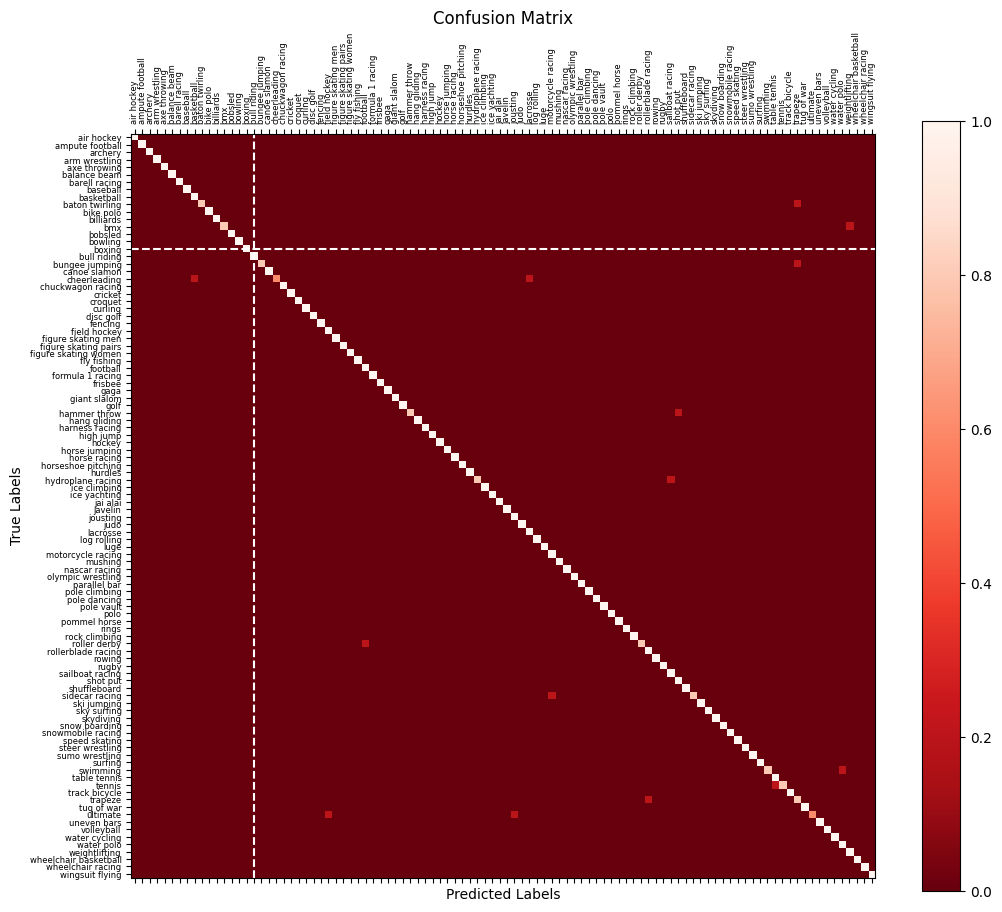

In [23]:
plot_confusion_matrix(cm, class_labels = class_labels)

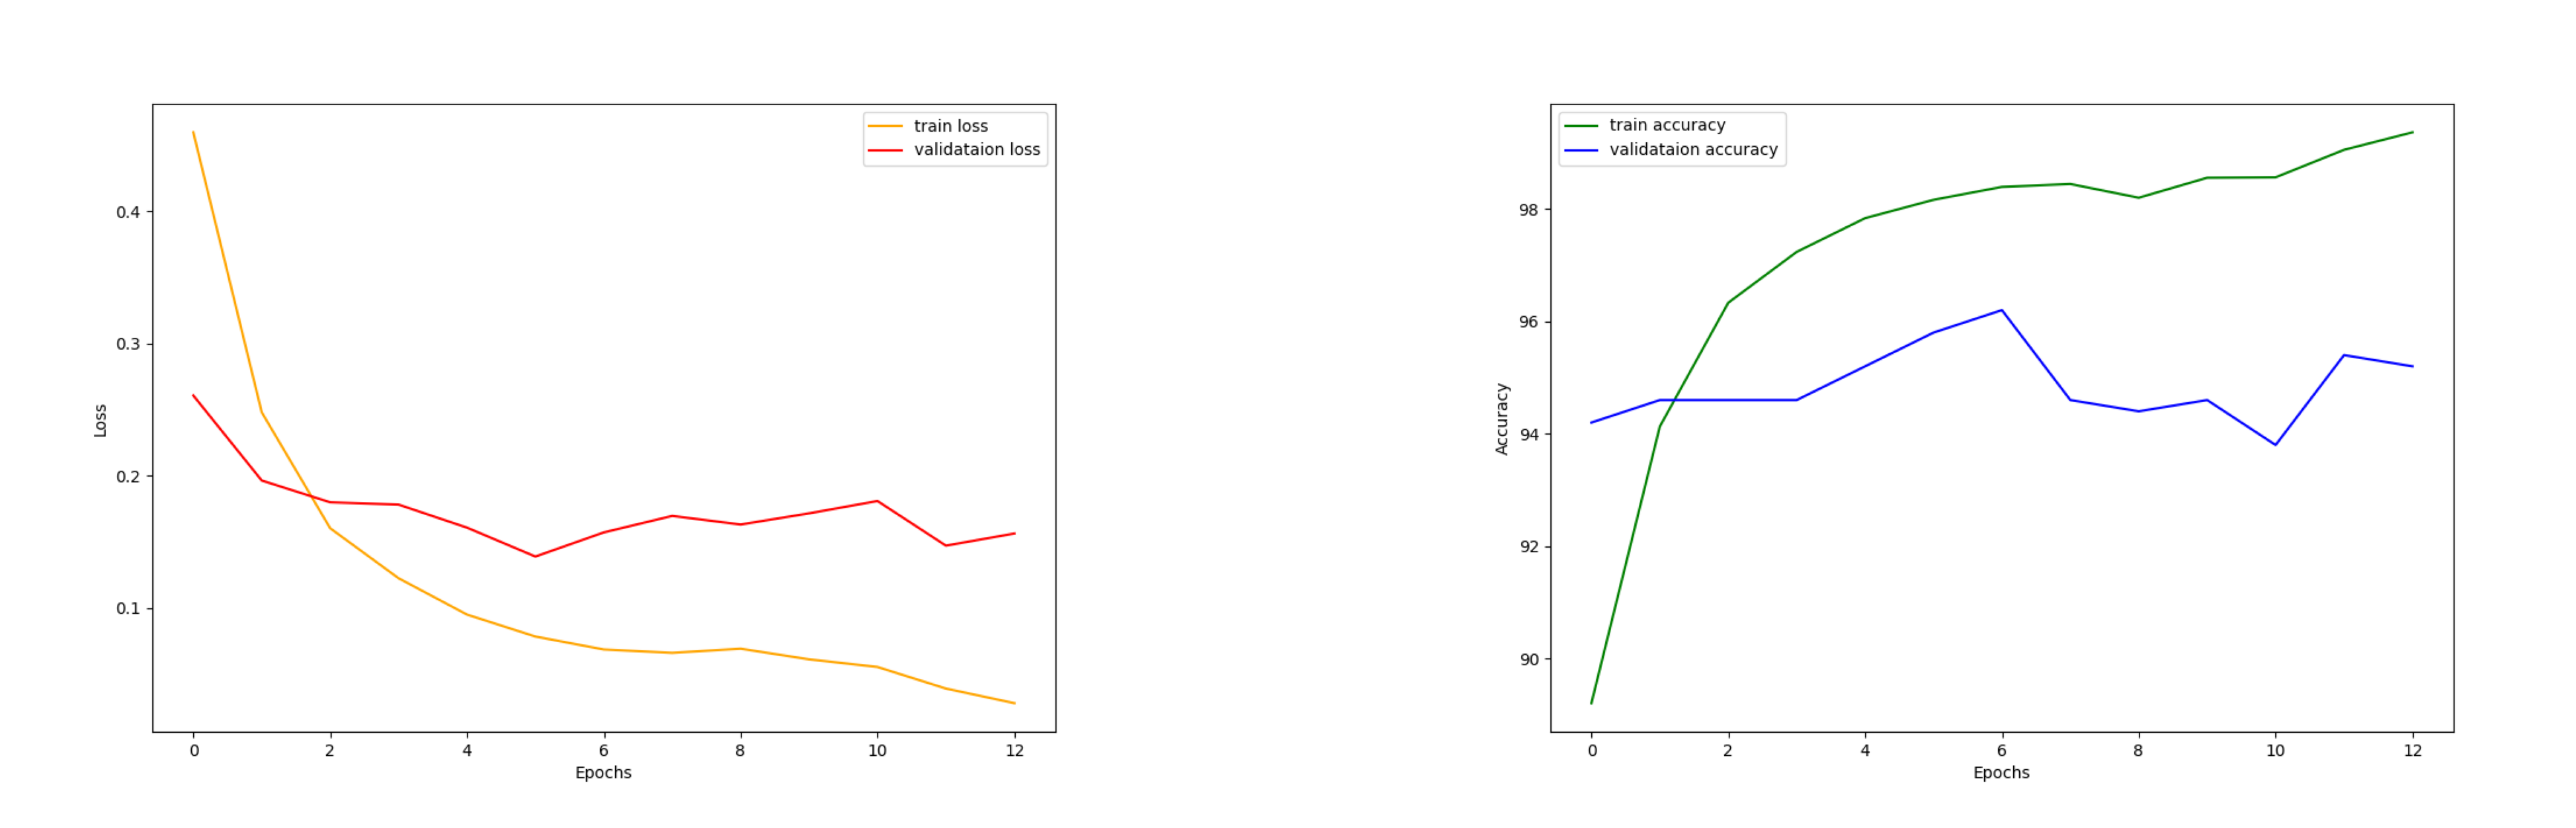

In [17]:
image1 = Image.open(os.path.join(home_path, "models/plots/FineTunedEfficientNet_21_06_loss_plot.png"))
image2 = Image.open(os.path.join(home_path, "models/plots/FineTunedEfficientNet_21_06_accuracy_plot.png"))

fig, axs = plt.subplots(1, 2, figsize=(50, 25))

axs[0].imshow(image1)
axs[0].axis('off')

axs[1].imshow(image2)
axs[1].axis('off')

plt.show()


### comment the metrics

## Class Activation Maps (CAM)

Class Activation Maps (CAM) are a visualization technique that allows us to understand which parts of an image contribute most to a model's prediction. CAM techniques help highlight the regions in the image that the model deems important for making its classification decision.

The basic principle behind CAM is to generate a pixel-level importance score for each location in the image. By overlaying this importance score on the image, we can visualize the regions that are most relevant to the predicted class.

In this use case, we will explore and apply multiple versions of CAM techniques to gain insights into our sport image classification model. These techniques typically involve modifying the model's architecture to incorporate global average pooling and generating the activation map from the final convolutional layer. By fusing this information with the class probabilities, we can visualize the discriminative regions in the image.

CAM provides an intuitive way to interpret and understand the decision-making process of our model. By visualizing the regions of interest, we can verify if the model focuses on relevant parts of the image for classification.

Stay tuned as we demonstrate and compare various CAM techniques in the subsequent sections.

*Note: Class Activation Maps (CAM) are just one of the many techniques available for interpretability and visualizing deep learning models. It is important to understand their limitations and use them in conjunction with other XAI techniques to gain a comprehensive understanding of model behavior.*


## CAM Implementation

In this section, we will focus on the implementation of Class Activation Maps (CAM) for our sport image classification task. CAM techniques allow us to visualize the important regions in an image that contribute to the model's classification decision.

For the CAM implementation, we will utilize the capabilities of the `omniXAI` Python library for XAI. `omniXAI` provides a comprehensive set of state-of-the-art XAI methods, including CAM, making it an ideal choice for our visualization needs.

As part of our platform, we aim to integrate `omniXAI` seamlessly into our environment, providing a user-friendly experience for exploring and applying CAM techniques. The platform acts as a bridge between our implementation and the powerful methods offered by `omniXAI`.

In this section, we will present four different CAM algorithms, including the following variations of Grad-CAM:
- Grad-CAM (Golden standard)
- Grad-CAM++
- LayerCAM
- ScoreCAM

These algorithms will allow us to gain insights into the important regions of the images and enhance our understanding of the classification decisions made by our model.




### Grad-CAM


The importance weights are computed by performing an element-wise multiplication between the feature map of the convolutional layer and the global average pooling of the gradients. This operation combines the spatial information captured by the feature map with the significance of the gradients, resulting in a set of weights that highlight the important regions of the image.

### GradCAM++

GradCAM++ is an extension of GradCAM, which also computes the importance weights to visualize the important regions in an image. However, GradCAM++ introduces a slight modification in how these weights are computed. Instead of using the global average pooling of the gradients, GradCAM++ utilizes a combination of positive and negative gradients to compute the importance weights. This modification allows GradCAM++ to capture more fine-grained details and produce more accurate visualizations compared to GradCAM. Overall, GradCAM++ is a powerful tool for interpreting and understanding the decision-making process of convolutional neural networks

### LayerCAM

LayerCAM is an advanced variant of GradCAM that addresses the issue of false positives in shallow layers, which can occur with GradCAM. The key difference lies in how LayerCAM computes the channel-wise weights. Instead of using the global average pooling of gradients, LayerCAM performs a channel-wise multiplication between the weights and the feature map's channels. This approach helps to refine the visualization and highlight the most relevant regions with greater accuracy. By incorporating this modification, LayerCAM enhances the interpretability and reliability of the generated heatmaps, making it a valuable tool for visualizing the importance of image regions in deep learning models.

### ScoreCAM


Score-CAM eliminates the reliance on gradients, which the authors argue may not be the optimal solution for generating pixel importance. Instead, Score-CAM calculates a score for each feature map during the forward pass. These feature maps are then used as masks on the original image, allowing the model to generate a forward-passing score specifically for the target class. By directly incorporating the feature maps as masks and computing the class-specific scores, Score-CAM provides a more direct and targeted approach for highlighting the important regions in an image, enhancing its interpretability and localization capabilities.

In [6]:
# import CAM implementation from omniXAI package

from omnixai.data.image import Image as omniImage
from omnixai.explainers.vision.specific.gradcam.pytorch.gradcam import GradCAM, LayerCAM, GradCAMPlus
from omnixai.explainers.vision.specific.scorecam.pytorch.scorecam import ScoreCAM

/home/arthur.babey/sports_env/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/arthur.babey/sports_env/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_orde

## Visualizing CAM Results

In this section, we will visualize the results obtained from the Class Activation Maps (CAM) techniques applied to our sport image classification task. The CAM techniques will enable us to highlight the regions of interest in the input images that contribute to the model's classification decisions.

By visualizing the CAM results, we aim to gain insights into the discriminative regions that our model focuses on when making predictions. This visualization will provide a better understanding of the model's decision-making process and help validate the accuracy and effectiveness of our classification model.

Stay tuned as we showcase the CAM visualizations for various sports images, allowing us to interpret and analyze the model's behavior in our sport image classification use case.


In [7]:
img1 = omniImage(Image.open(os.path.join(home_path, "data/test/archery/1.jpg")).convert('RGB'))
img2 = omniImage(Image.open(os.path.join(home_path, "data/test/judo/1.jpg")).convert('RGB'))
img3 = omniImage(Image.open(os.path.join(home_path, "data/test/football/1.jpg")).convert('RGB'))
img4 = omniImage(Image.open(os.path.join(home_path, "data/test/nascar racing/3.jpg")).convert('RGB'))


In [ ]:
preprocess = lambda ims: torch.stack([test_transform()(im.to_pil()) for im in ims])

explainer = GradCAM(
    model=model,
    target_layer=model.model.features[-1][0],
    preprocess_function=preprocess
)
# Explain the top label
explanations = explainer.explain(img1)
explanations.ipython_plot(index=0, class_names=class_labels)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



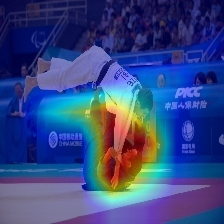
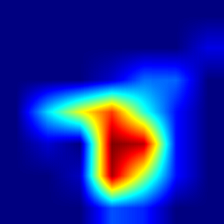

In [37]:
explainer = GradCAMPlus(
    model=model,
    target_layer=model.model.features[-1][0],
    preprocess_function=preprocess
)
# Explain the top label
explanations = explainer.explain(img2)
explanations.ipython_plot(index=0, class_names=class_labels)


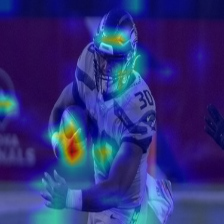
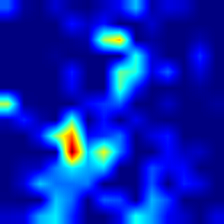

In [41]:
explainer = LayerCAM(
    model=model,
    target_layer=model.model.features[-4][0],
    preprocess_function=preprocess
)
# Explain the top label
explanations = explainer.explain(img3)
explanations.ipython_plot(index=0, class_names=class_labels)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1536/1536 [00:38<00:00, 39.43it/s]



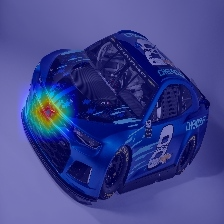
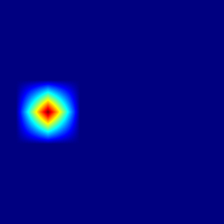

In [46]:
explainer = ScoreCAM(
    model=model,
    target_layer=model.model.features[-1][0],
    preprocess_function=preprocess
)
# Explain the top label
explanations = explainer.explain(img4)
explanations.ipython_plot(index=0, class_names=class_labels)

## Improving Your Model with CAM

Class Activation Maps (CAM) not only provide valuable insights into the decision-making process of our model but can also be used to identify potential areas for model improvement. In this section, we will leverage CAM techniques to identify an issue in our sport image classification models and present a solution to address it.

By analyzing the CAM visualizations, we can identify instances where our model might misclassify images due to focusing on irrelevant or misleading regions. These misclassifications can provide valuable hints about potential weaknesses in the model's understanding of certain sports or image characteristics.

Using the insights gained from CAM, we will propose a solution to address the identified issue and improve the model's performance. This may involve fine-tuning specific layers, adjusting the training strategy, or incorporating additional data augmentation techniques.

Through this exercise, we aim to demonstrate the practical application of CAM in not only understanding model behavior but also in guiding model improvements. By leveraging the interpretability provided by CAM, we can iteratively refine our sport image classification models and achieve better accuracy and robustness.

Stay tuned as we dive into the CAM analysis, identify the issue, propose a solution, and evaluate the impact of the improvements on the model's performance.


---
First let's have a look at the model's prediction and gradcam's result on a axe throwing image, what do you expect ? 

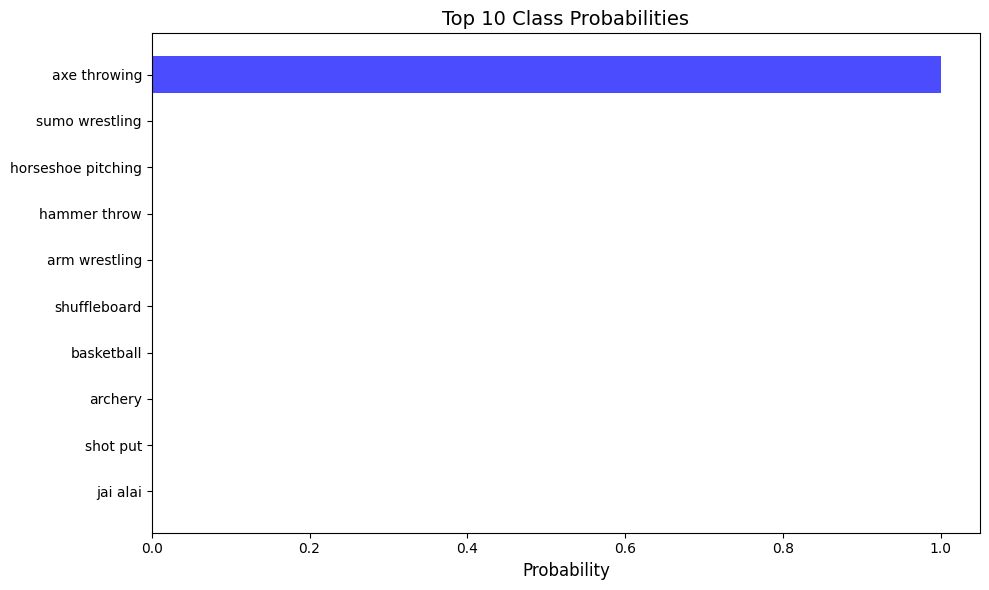


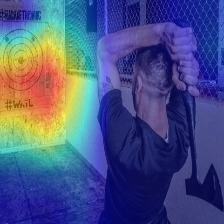
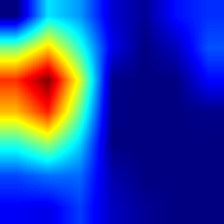

In [10]:
axe1 = omniImage(Image.open(os.path.join(home_path, "data/test/axe throwing/2.jpg")).convert('RGB'))

plot_prediction(model, os.path.join(home_path, "data/test/axe throwing/2.jpg"), test_transform(), class_dict)
explainer = GradCAM(
    model=model,
    target_layer=model.model.features[-1][0],
    preprocess_function=preprocess
)
# Explain the top label
explanations = explainer.explain(axe1)
explanations.ipython_plot(index=0, class_names=class_labels)

What do you notice ? First we can see that the model is very confident about its prediction and it is correct, good point. But looking at the Grad-CAM's result we note that the model is not using the axe to classify axe throwing which could be missleading. The model ignores the axe and focuses solely on the target.

Let's investigate..


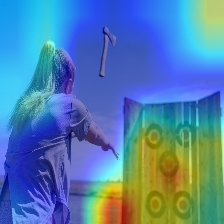
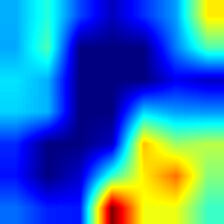


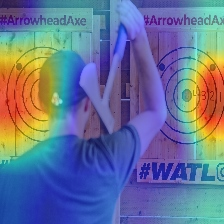
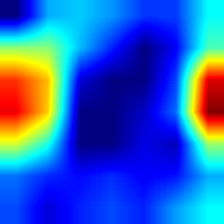


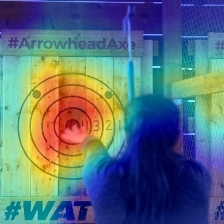
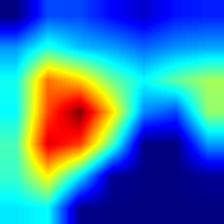


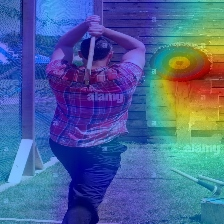
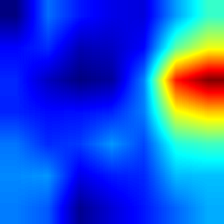

In [14]:
axe1 = omniImage(Image.open(os.path.join(home_path, "data/test/axe throwing/1.jpg")).convert('RGB'))
axe3 = omniImage(Image.open(os.path.join(home_path, "data/test/axe throwing/3.jpg")).convert('RGB'))
axe4 = omniImage(Image.open(os.path.join(home_path, "data/test/axe throwing/4.jpg")).convert('RGB'))
axe5 = omniImage(Image.open(os.path.join(home_path, "data/test/axe throwing/5.jpg")).convert('RGB'))

axes = omniImage(data=np.concatenate([axe1.to_numpy(), axe3.to_numpy(), axe4.to_numpy(), axe5.to_numpy()]), batched=True)

explanations = explainer.explain(axes)

for i in range(4):
    explanations.ipython_plot(index=i, class_names=class_labels)

Upon analysis, it appears that in all the images depicting axe throwing in our dataset, there is a distinct target present. Surprisingly, our model seems to solely rely on the presence of the target to classify the image, disregarding the importance of the axe itself. This behavior raises concerns since the model should be able to classify axe throwing based on the presence of an axe, regardless of whether the target is visible or not.

Now, let's examine the performance of our model on an axe throwing image where the target is not visible. By doing so, we can evaluate if the model truly understands the key features associated with axe throwing or if it heavily relies on the presence of the target.

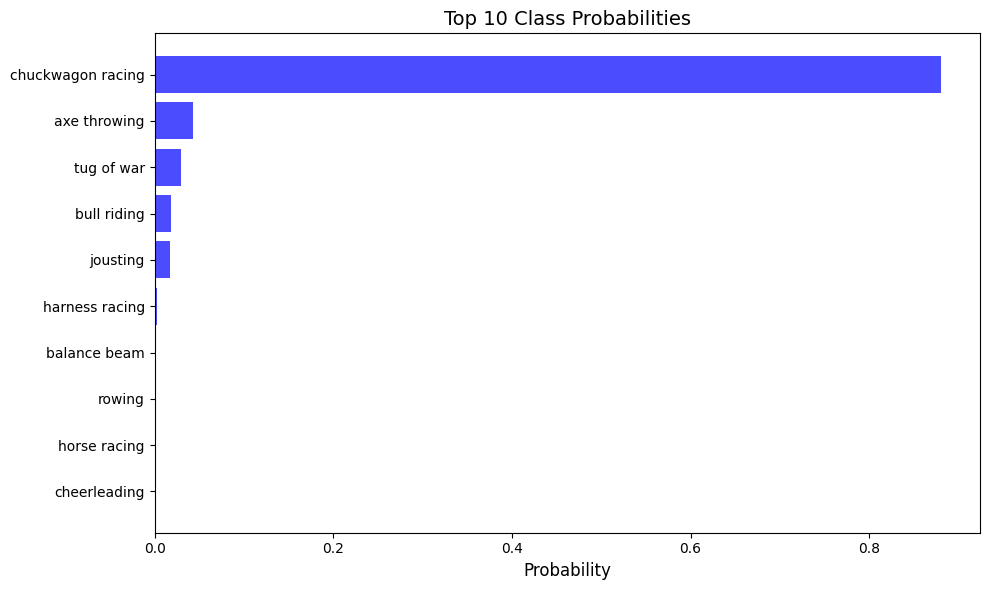


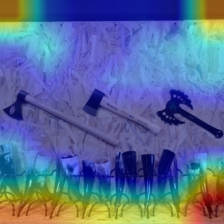
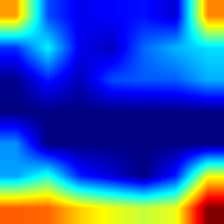

In [18]:
new_axe = omniImage(Image.open(os.path.join(home_path, "data/hache.jpg")).convert('RGB'))
explanations = explainer.explain(new_axe)
plot_prediction(model, os.path.join(home_path, "data/hache.jpg"), test_transform(), class_dict)
explanations.ipython_plot(index=0, class_names=class_labels)

As anticipated, the model fails to predict axe throwing for this particular challenging image. One of the main reasons for this is the absence of similar images in the training dataset. While a human observer could infer the class of the image based on the presence of three axes, our model lacks the exposure to labeled images of axe throwing without a target. Consequently, it fails to establish a connection between the concept of axes and the sport of axe throwing.

One potential solution is to augment the dataset by adding new images and then retrain the model. By incorporating a more diverse set of images, we can provide the model with additional examples of axe throwing without a target, enabling it to learn the association between axes and the sport more effectively. After this retraining process, we can utilize XAI and Class Activation Maps (CAM) to examine whether the model has successfully overcome the bias present in the original dataset.

This bias, resulting from the limited representation of axe throwing without a target, is known as dataset bias. Through XAI techniques such as CAM, we can gain insights into how the model's attention is focused and determine whether it has acquired the ability to accurately identify and classify axe throwing instances, even in the absence of a visible target.

## Conclusion:

Throughout this notebook, we delved into the utilization of CAM methods for sport classification using a dedicated dataset. By implementing various CAM techniques, we were able to visualize and interpret the important regions in the images that influenced the model's classification decisions.

By employing CAM, including GradCAM, GradCAM++, LayerCAM, and ScoreCAM, we gained valuable insights into the model's behavior and detected potential biases within the classification process. We observed instances where the model heavily relied on specific features, such as the presence of a target, rather than considering other relevant visual cues, like the presence of an axe for axe throwing classification.

These findings highlight the importance of dataset diversity and representation when training classification models. It became evident that including images labeled specifically for axe throwing without a target could potentially address the bias issue we encountered. Additionally, the integration of CAM methods allowed us to identify and address these biases, ultimately leading to improvements in the model's performance.

Moving forward, we can explore strategies such as augmenting the dataset with diverse and representative images, conducting retraining, and applying CAM techniques to reassess the model's ability to identify and classify sports accurately.

By leveraging the power of CAM methods, we gained deeper insights into the inner workings of our sport classification model, paving the way for further improvements and advancements in our classification tasks.

## References

1. [Name of Paper](Link to the Paper)
2. [Name of Article](Link to the Article)
3. [Name of Book](Link to the Book)


In [7]:
model = FineTunedEfficientNet()

In [8]:
data = pd.read_csv("../data/sports.csv")
data.head()
data["image_path"]="../data/"+data["filepaths"]
lbl=LabelEncoder()
data["labels_encoded"]=lbl.fit_transform(data["labels"])
data.head()

,class id,filepaths,labels,data set,image_path,labels_encoded
0,0,train/air hockey/001.jpg,air hockey,train,../data/train/air hockey/001.jpg,0
1,0,train/air hockey/002.jpg,air hockey,train,../data/train/air hockey/002.jpg,0
2,0,train/air hockey/003.jpg,air hockey,train,../data/train/air hockey/003.jpg,0
3,0,train/air hockey/004.jpg,air hockey,train,../data/train/air hockey/004.jpg,0
4,0,train/air hockey/005.jpg,air hockey,train,../data/train/air hockey/005.jpg,0


In [9]:
import pandas as pd

# Assuming you have a DataFrame called 'df' with columns 'class_id' and 'label'
class_dict = dict(zip(data['class id'], data['labels']))


In [10]:
import json

# Assuming you have a class_dict containing the class ID to label mapping

# Convert the class dictionary to JSON format
class_dict_json = json.dumps(class_dict)

# Write the JSON data to a file
with open('../data/class_dict.json', 'w') as file:
    file.write(class_dict_json)


In [11]:
data = data[~data['image_path'].str.endswith('.lnk')]

In [12]:
df_train=data[data["data set"]=="train"].reset_index(drop=True)
df_valid =data[data["data set"]=="valid"].reset_index(drop=True)
df_test=data[data["data set"]=="test"].reset_index(drop=True)

In [14]:
train_dataset=SportsData(df=df_train,transform=train_transform())
valid_dataset=SportsData(df=df_valid,transform=train_transform())
test_dataset=SportsData(df=df_test, transform=test_transform())

train_loader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle=True)
val_loader = DataLoader(dataset = valid_dataset, batch_size = 32, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size = 32, shuffle=True)

In [ ]:
def train(model, train_loader, optimizer, criterion):

    model.train()
    print("Training")
    train_loss = 0.0
    train_correct = 0.0
    counter = 0

    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):

        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()

        #forward pass
        outputs = model(image)
        #labels = torch.max(labels, dim=1)  # Convert one-hot encoded vectors to class labels

        # compute loss
        loss = criterion(outputs, labels.long())
        train_loss += loss.item()
        
        # compute accuracy
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()

        # backprop
        loss.backward()

        #update the weights
        optimizer.step()

    epoch_loss = train_loss / counter
    epoch_acc = 100. * (train_correct / len(train_loader.dataset))
    return  epoch_loss, epoch_acc



def validate(model, val_loader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(val_loader), total=len(val_loader)):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.float().to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels.long())
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(val_loader.dataset))
    return epoch_loss, epoch_acc



In [ ]:
def load_model(name):
    """
    Function to load a saved model from disk.
    """

    checkpoint = torch.load(f"/home/arthur.babey/workspace/hes-xplain-arthur/use_case_sport_classification/models/saved_models/{name}.pth")

    epochs = checkpoint['epoch']
    model = FineTunedEfficientNet()  
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = FineTunedEfficientNet(model.parameters())  
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    criterion = checkpoint['loss']

    print("Model loaded :)")

    return epochs, model, optimizer, criterion

import seaborn as sns
import matplotlib.pyplot as plt




In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
epochs=15

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")


train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_model = None
best_val_acc = -float('inf')
early_stop_counter = 0
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)

# training
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch + 1} of {epochs}")
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    scheduler.step(val_acc)
    print(f"Training loss: {train_loss:.3f}, training acc: {train_acc:.3f}")
    print(f"Validation loss: {val_loss:.3f}, validation acc: {val_acc:.3f}")
    print('-' * 50)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model.state_dict()
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    if early_stop_counter >= 6:
        print("early stop")
        break
    print(f"Early counter = {early_stop_counter}")

# save the trained model weights
save_model(epochs, model, optimizer, criterion, "FineTunedEfficientNet_21_06")
# save the loss and accuracy plots
save_plots(train_accs, val_accs, train_losses, val_losses, "FineTunedEfficientNet_21_06")






In [ ]:
import matplotlib.pyplot as plt


In [ ]:
# save the trained model weights
save_model(epochs, model, optimizer, criterion, "FineTunedEfficientNet_21_06")
# save the loss and accuracy plots
save_plots(train_accs, val_accs, train_losses, val_losses, "FineTunedEfficientNet_21_06")


In [ ]:
def load_model_state(model, name):
    """
    Function to load only the model's state dictionary from a checkpoint.
    """
    checkpoint = torch.load(f"/home/arthur.babey/workspace/hes-xplain-arthur/use_case_sport_classification/models/saved_models/{name}.pth")

    model.load_state_dict(checkpoint['model_state_dict'])
    print("Model state loaded :)")


model = FineTunedEfficientNet()
load_model_state(model, "FineTunedEfficientNet_21_06")


In [ ]:
def evaluate(model_path, test_loader):


    # loading model
    model = FineTunedEfficientNet()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"The device is : {device}")
    checkpoint = torch.load(model_path, map_location=device)
    print('Loading trained model weights...')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    correct, total, f1 = 0, 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        model.eval()
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # move the labels to the device

            # forward pass
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=1)

            # squeeze the labels to match
            #labels = torch.argmax(labels, dim=1)

            # update total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            f1 += f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro') * labels.size(0)
            # append true and predicted labels for confusion matrix
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    F1s = 100 * f1 / total
    accuracy = 100 * correct / total

    print(f"Test accuracy: {accuracy:.2f}%")
    print(f"Test f1 score: {F1s:.2f}%")

    # compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    return accuracy, F1s, cm


In [ ]:
model_path = "/home/arthur.babey/workspace/hes-xplain-arthur/use_case_sport_classification/models/saved_models/FineTunedEfficientNet_21_06.pth"
_,_,cm = evaluate(model_path, test_loader)

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, balanced_accuracy_score


In [ ]:
class_labels = list(class_dict.values())